# Logistic distribution (unit): specification, parameter estimation, sampling

Author: Jyri Kivinen (jyri.kivinen@lapinamk.fi)

Version: Draft as of 8 October, 2023. 

Version history: Initial version published on 4 Oct. 2023, some updates thereafter. 

In [1]:
# library imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Logistic sigmoid function
The function can be written as $\mathrm{sig}(x)=\frac{1}{1+\mathrm{exp}{\{-x\}}}.$ 
A long-standing and widely used application of the function is in specifying the activation or the probability of activation of a neuron, 
in the context of artificial neural networks. Below we implement to evaluate the function and also plot it.

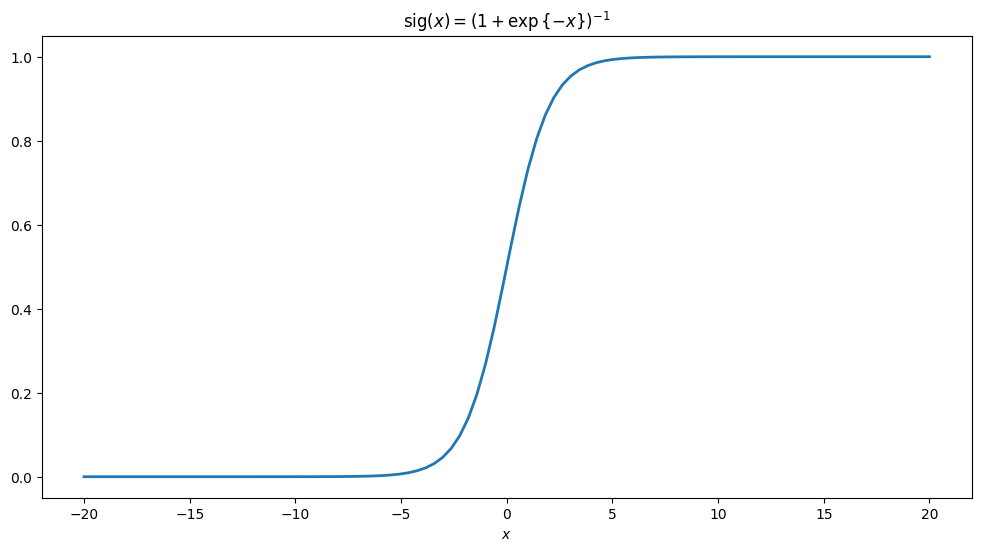

In [2]:
x = np.linspace(-20, 20, 100)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[12, 6])
ax.plot(x,  1./(1.+np.exp(-x)), linewidth=2)
ax.set_xlabel(r'$x$')
ax.set_title(r'$\mathrm{sig}(x)=(1+\exp{\{-x\}})^{-1}$');

## A more general form 
Let us consider the generalization $\mathrm{sig}(x; \mu, s)=\frac{1}{1+\mathrm{exp}{\{-(x-\mu)/s}\}}.$

Obviously with $\mu=0$ and $s=1$ we recover the standard expression. Let us plot it with also some other values of the variables/parameters.

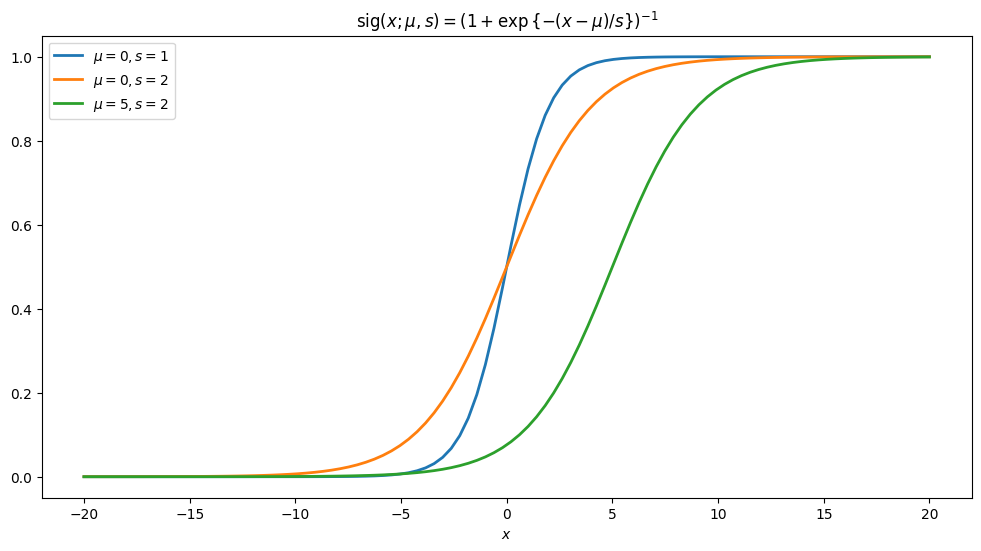

In [3]:
x = np.linspace(-20, 20, 100)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[12, 6])
for mu, s in zip([0, 0, 5],[1, 2, 2]):
    ax.plot(x,  1./(1.+np.exp(-(x-mu)/s)), linewidth=2, label='$\mu={}, s={}$'.format(mu, s));
ax.set_xlabel(r'$x$')
ax.set_title(r'$\mathrm{sig}(x; \mu, s)=(1+\exp{\{-(x-\mu)/s\}})^{-1}$')
plt.legend();

We can see that $\mu$ "shifts" and $s$ "streches" the graph. It can be conceived that the generalization could be used, e.g., in dealing with distributional shifts, or for example multitask/transfer learning; as an example, the $x$ could be the linear response by the canonical network unit, and the $\mu$ and $s$ would be (additional, perhaps class/task/etc.-specific and particularly shared) parameters to tune - in the context of fine-tuning an obvious strategy would be to introduce the shifting and scaling parameters, and initialize their values so that the standard expression is obtained. Perhaps such have been already done.

In the following, we will study it in a different context. We will use it in defining cumulative distribution function, and in fact it is cumulative distribution of the logistic distribution.

## The logistic distribution
The cumulative distribution function of the distribution is $P(x|\mu, s)=\frac{1}{1+\mathrm{exp}{\{-(x-\mu)/s}\}}=\mathrm{sig}(x; \mu, s).$

We can obtain the probability density function by differentiation: $p(x|\mu, s)=\frac{\mathrm{d}}{\mathrm{dx}}P(x|\mu, s).$ 

With also a bit of algebra, we can obtain that $p(x|\mu, s)=\frac{1}{s}\mathrm{sig}(x; \mu, s)(1-\mathrm{sig}(x; \mu, s)).$ 

The form may not be previously that well-known (for example, <a href="https://en.wikipedia.org/wiki/Logistic_distribution">Wikipedia, page generated 8 Oct., 2023</a> does not mention it), but I find it a natural one in/for the neural networks/machine learning context. Note that the expression also equals to $\frac{\mathrm{d}}{\mathrm{dx}}\mathrm{sig}(x; \mu, s)$ and how simply and nicely the form changes by the generalization; the classical/standard form is obtained by plugging in $\mu=0$, $s=1$. See Appendix for further derivations.

Below we implement Python-functions to evaluate the functions, and plot the probability density function and cumulative distribution function with several parameter value configurations. As we can see, the parameter $\mu$ is a location parameter, and $s$ controls the scale (which needs to be positive).

In [4]:
def logistic_sigmoid(x, loc=0, scale=1):
    return 1./(1.+np.exp(-(x-loc)/scale))

def logistic_sigmoid_derivative(x, loc=0, scale=1):
    log_sig = logistic_sigmoid(x, loc=loc, scale=scale)
    return (1./scale)*log_sig*(1.-log_sig)

def cumulative_distribution_function(x, loc=0, scale=1):
    return logistic_sigmoid(x, loc=loc, scale=scale)

def probability_density_function(x, loc=0, scale=1):
    return logistic_sigmoid_derivative(x, loc=loc, scale=scale)

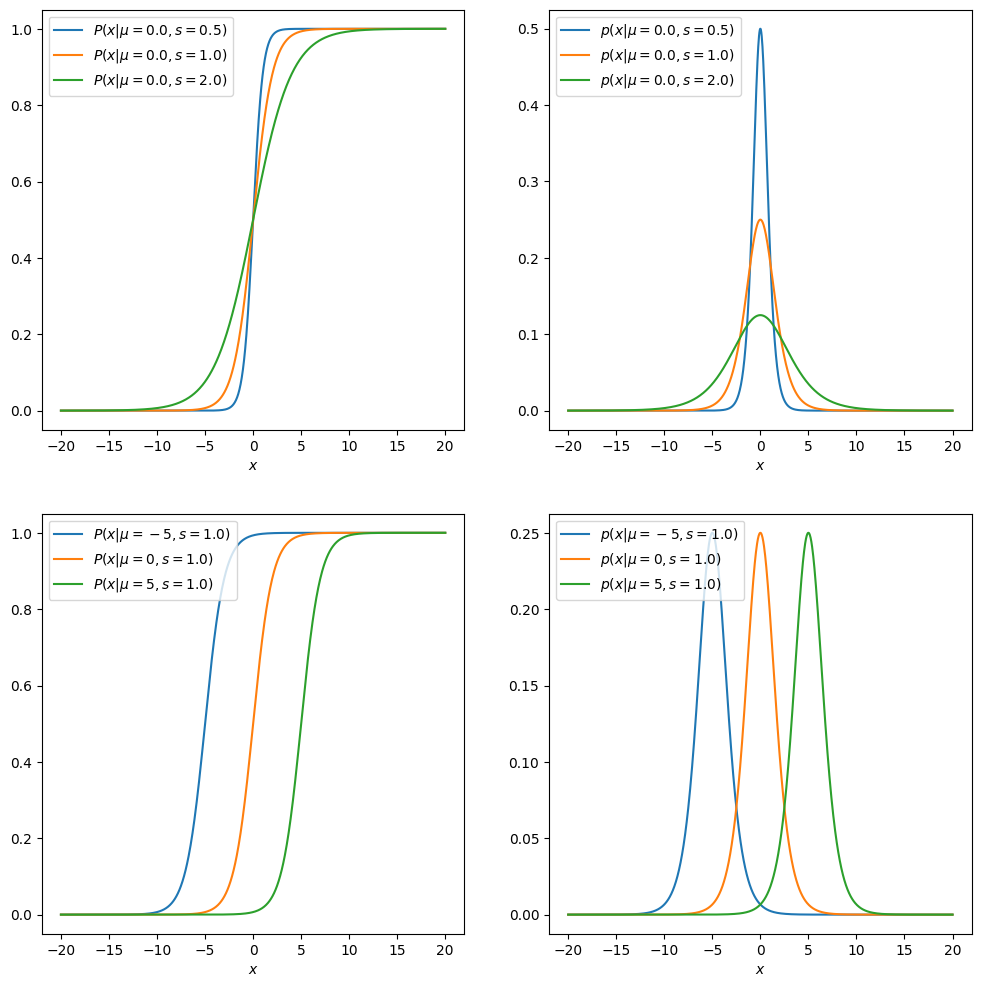

In [5]:
x = np.linspace(-20, 20, 1000)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[12, 12])
# fixed location parameter (mu), varied scale parameter (s)
loc = 0.
for scale in np.array([0.5, 1, 2]):
    ax[0, 0].plot(x, cumulative_distribution_function(x, loc, scale), label=r'$P(x|\mu={}, s={})$'.format(loc, scale))
    ax[0, 1].plot(x, probability_density_function(x, loc, scale), label=r'$p(x|\mu={}, s={})$'.format(loc, scale))
# varied location parameter (mu), fixed scale parameter (s)
scale = 1.
for loc in np.array([-5, 0, 5]): 
    ax[1, 0].plot(x, cumulative_distribution_function(x, loc, scale), label=r'$P(x|\mu={}, s={})$'.format(loc, scale))
    ax[1, 1].plot(x, probability_density_function(x, loc, scale), label=r'$p(x|\mu={}, s={})$'.format(loc, scale))
# set axis labels, legends
for ii in np.arange(2):
    for jj in np.arange(2):
        ax[ii, jj].set_xlabel(r'$x$')
        ax[ii, jj].legend(loc='upper left');

## Sampling from the distribution, comparing histogram of samples to pdf
In order to draw samples, we can use the inverse-CDF method; to draw a sample, we draw a sample from a uniform distribution, $\dot{u}\sim \mathrm U(0, 1)$, and see for which random variable value the cumulative distribution function of the logistic distribution obtains the value, i.e., evaluate the inverse of the cumulative distribution function also known as the quantile function, at $\dot{u}$. The quantile function, is easily obtained (see e.g. the Appendix), and can be written as $Q(y| \mu, s) = \mu + s \log{\{y/(1-y)\}}.$

Below we implement a Python-function to draw samples from the distribution, and utilize it to draw samples from logistic distributions. We also compare density estimates via histograms of samples to the analytical pdfs, graphically via density (estimate) curves.

In [6]:
# function to draw samples from the distribution
def random_samples(size, loc=0, scale=1):
    samples_from_uniform = np.random.random_sample(size=size)
    return loc+scale*np.log(samples_from_uniform/(1.-samples_from_uniform))

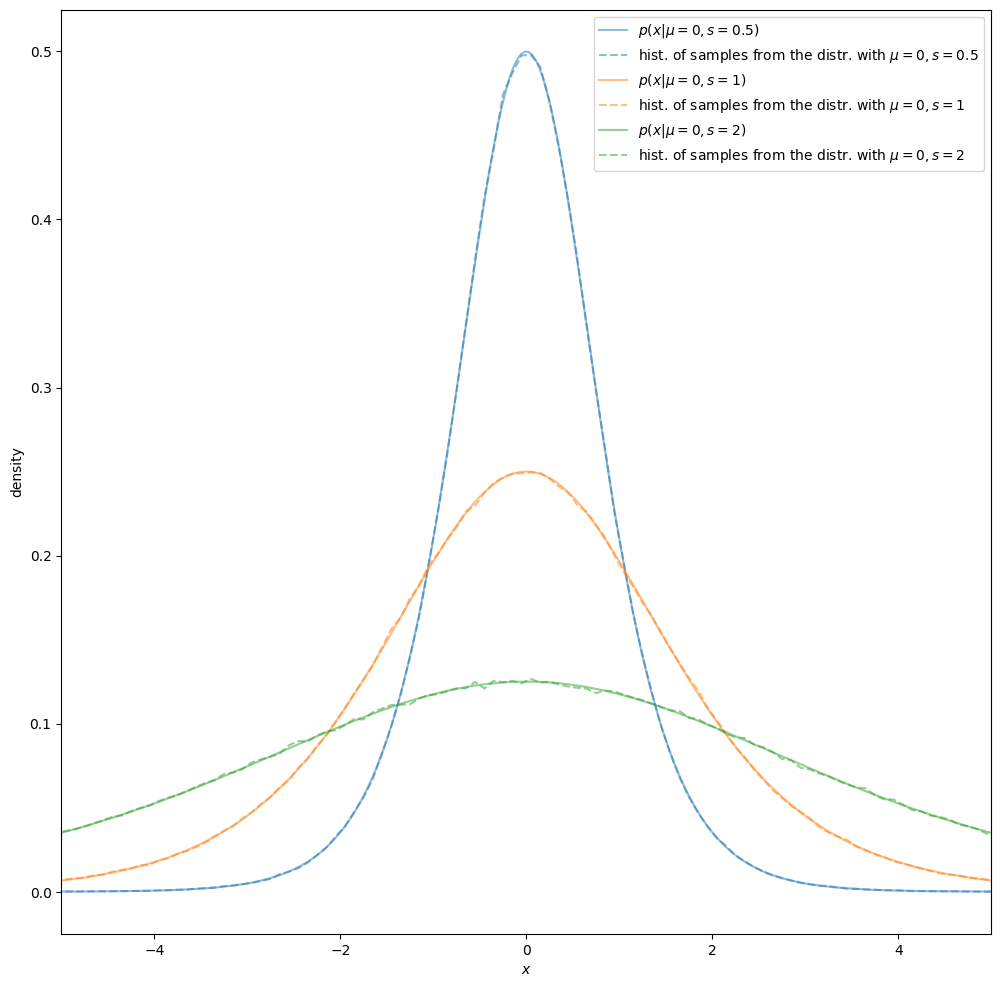

In [7]:
# infrastructure creation
fix, ax = plt.subplots(figsize=[12, 12])
nsamples = 1000000; nbins = 1000
bins = np.linspace(-50, 50, nbins+1); bin_centers = 0.5*(bins[0:-1]+bins[1:])
colors_hex = plt.rcParams['axes.prop_cycle'].by_key()['color']

# sampling, histogram calculation, plotting
loc=0; scales = [0.5, 1, 2]
for scale_index, scale in enumerate(scales):
    linecolor = colors.to_rgb(colors_hex[scale_index])
    samples = random_samples(size=nsamples, loc=loc, scale=scale) 
    [densities, _] = np.histogram(samples, bins, density=True)
    ax.plot(x, probability_density_function(x, loc=loc, scale=scale), 
            color=linecolor, linestyle='solid', label=r'$p(x|\mu={}, s={})$'.format(loc, scale), alpha=0.5)
    ax.plot(bin_centers, densities, color=linecolor, linestyle='dashed', 
            label=r'hist. of samples from the distr. with $\mu={}, s={}$'.format(loc, scale), alpha=0.5)
ax.set_xlim([-5, 5]); ax.set_xlabel(r'$x$'); ax.set_ylabel('density'); ax.legend();

## Estimating parameter values from data (samples)
Here, we use the method of moments as the estimation method, to estimate the distribution parameter values $\mu$ and $s$ from data. Mean and variance of the logistic distribution are $\mu$ and $\frac{(s\pi)^2}{3}$, respectively (<a href="https://en.wikipedia.org/wiki/Logistic_distribution">Wikipedia, page generated 4 Oct., 2023</a>). Let $\bar{x}=\frac{1}{N}\sum_{n=1}^{N}{x^{(n)}}$ denote the empirical mean, and $S^2=\frac{1}{N-1}\sum_{n=1}^{N}(x^{(n)}-\bar{x})^2$ the empirical variance.

Matching the empirical moments to the theoretical ones, we have that $\hat{\mu}=\bar{x}$, and $\frac{(\hat{s}\pi)^2}{3} = S^2$.

Therefore, we find that our estimate for the mean $\hat{\mu}=\bar{x}$ and the estimate for the scale parameter $\hat{s}=\frac{\sqrt{3S^2}}{\pi}.$

Below, we apply the estimation in the context of a particular logistic distribution: We define the parameter values of the distribution, draw samples from it and apply the method of moments to estimate the parameter values from the samples. We also assess the estimation effectiveness, qualitatively by plotting the true and estimated distributions, and quantitatively by an approximation to the Kullback-Leibler divergence of true to estimated distribution, via Monte Carlo (see Appendix for the math).

### Model definition, sampling, estimation from samples

In [8]:
# specify distribution parameters
loc=-5; scale = 2

# sample from the distribution
nsamples = 10000
samples = random_samples(size=nsamples, loc=loc, scale=scale)

# calculate empirical moments
sample_mean = np.sum(samples)/nsamples
sample_variance = np.sum((samples-sample_mean)**2)/(nsamples-1)

# estimate parameter values based on the method of moments; 
# empirical moments are matched to theoretical ones
loc_est = sample_mean
scale_est = np.sqrt(3*sample_variance)/np.pi

### Assessment of estimation effectiveness
Compare true and estimated distribution.

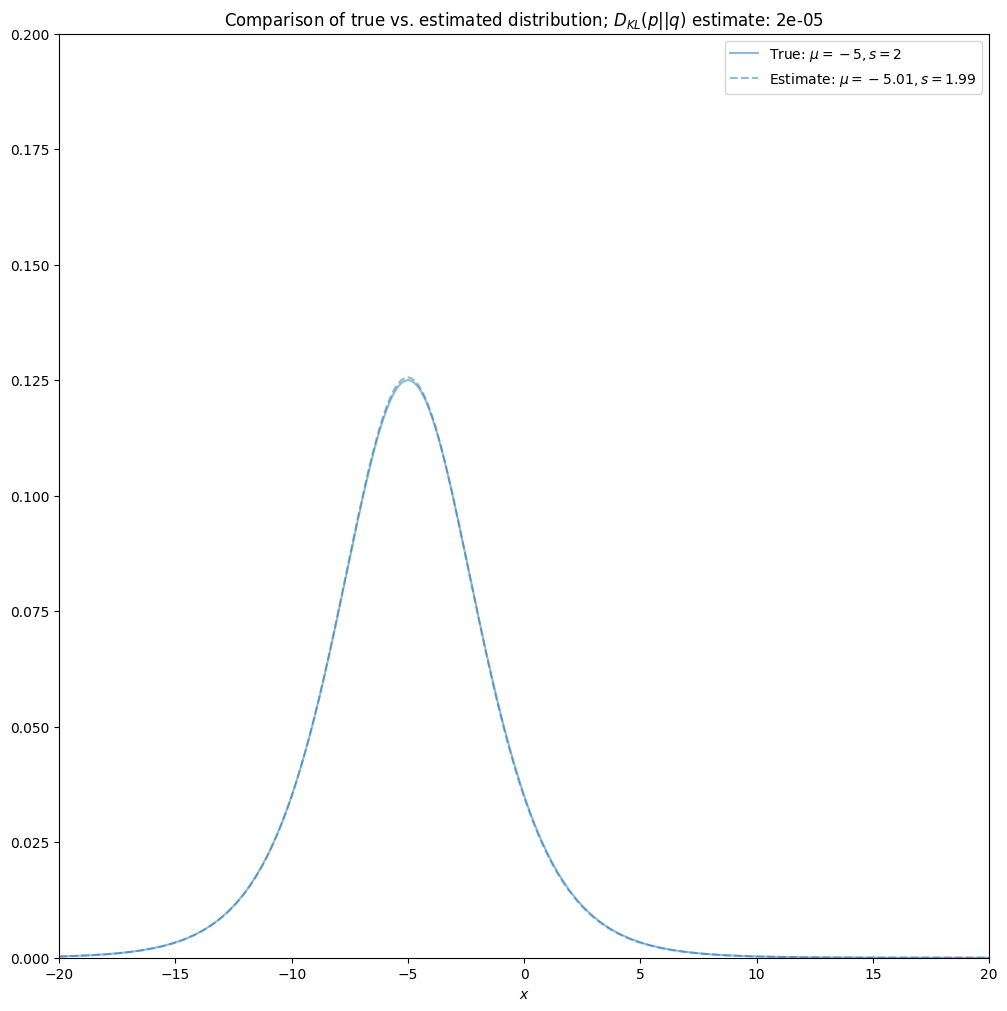

In [9]:
# quantitative evaluation:
# -------------------------

# Kullback-Leibler divergence of true to estimated distributions, D_KL (p||q), estimated using Monte Carlo
nsamples = 1000000 # for Monte Carlo
samples = random_samples(size=nsamples, loc=loc, scale=scale)
KL_divergence_est = (1./nsamples)*np.sum(np.log(probability_density_function(samples, loc=loc, scale=scale)) \
                                         -np.log(probability_density_function(samples, loc=loc_est, scale=scale_est)))

# qualitative evaluation:
# ------------------------

# plot the distributions, report also the KL-divergence
fix, ax = plt.subplots(figsize=[12, 12])
linecolor = colors.to_rgb(colors_hex[0])
ax.plot(x, probability_density_function(x, loc=loc, scale=scale), color=linecolor, linestyle='solid', 
        label=r'True: $\mu={}, s={}$'.format(loc, scale), alpha=0.5)
ax.plot(x, probability_density_function(x, loc=loc_est, scale=scale_est), color=linecolor, linestyle='dashed', 
        label=r'Estimate: $\mu={}, s={}$'.format(np.round(loc_est, 2), np.round(scale_est, 2)), alpha=0.5)
ax.set_ylim([0, 0.2]); ax.set_xlim([-20, 20]); ax.set_xlabel(r'$x$'); ax.legend()
ax.set_title(r'Comparison of true vs. estimated distribution; $D_{KL}(p||q)$ estimate: '+str(np.round(KL_divergence_est, 5)));

## Appendix: some further details, derivations

### The (partial) derivatives

The expression $\frac{\mathrm{d}}{\mathrm{dx}}\mathrm{sig}(x; \mu, s)=\frac{1}{s}\mathrm{sig}(x; \mu, s)(1-\mathrm{sig}(x; \mu, s))$ is, as well as
the derivatives of $\mathrm{sig}(x; \mu, s)$ w.r.t. $\mu$ and $s$ are, straightforward to obtain from the fact that $\frac{\mathrm{d}}{\mathrm{dx}}\mathrm{sig}(x)=\mathrm{sig}(x)(1-\mathrm{sig}(x))$. This is because for example $\mathrm{sig}(x;\mu, s)=\mathrm{sig}((x-\mu)/s)$ and that $\frac{\mathrm{d}}{\mathrm{dx}}\mathrm{sig}((x-\mu)/s)=\frac{\mathrm{d}}{\mathrm{d (x-\mu)/s}}\mathrm{sig}((x-\mu)/s)\frac{\mathrm{d}}{\mathrm{dx}}(x-\mu)/s$ which simplifies to $\mathrm{sig}((x-\mu)/s)(1-\mathrm{sig}((x-\mu)/s))\frac{1}{s}$, and can be then rewritten as $\frac{1}{s}\mathrm{sig}(x; \mu, s)(1-\mathrm{sig}(x; \mu, s))$. 

Deriving $\frac{\mathrm{d}}{\mathrm{dx}}\mathrm{sig}(x)=\mathrm{sig}(x)(1-\mathrm{sig}(x))$ can be done as follows: Starting from $\frac{\mathrm{d}}{\mathrm{dx}}\mathrm{sig}(x)=\frac{\mathrm{d}}{\mathrm{dx}}(1+\mathrm{exp}{\{-x}\})^{-1}$, we obtain that these equal to $(-1)\cdot (1+\mathrm{exp}{\{-x}\})^{-2}\cdot\mathrm{exp}{\{-x}\}\cdot(-1)$. This can be written as $\left(\frac{1}{1+\mathrm{exp}{\{-x}\}}\right)\left(\frac{\mathrm{exp}{\{-x}\}}{1+\mathrm{exp}{\{-x}\}}\right)$, a product of two terms. The term on the right $\frac{\mathrm{exp}{\{-x}\}}{1+\mathrm{exp}{\{-x}\}}=\frac{1+\mathrm{exp}{\{-x}\}-1}{1+\mathrm{exp}{\{-x}\}}$, which we can write as $1-\frac{1}{1+\mathrm{exp}{\{-x}\}}$. Plugging in the definition $\frac{1}{1+\mathrm{exp}{\{-x}\}}=\mathrm{sig}(x)$ to both of the two terms mentioned, we arrive to the result $\frac{\mathrm{d}}{\mathrm{dx}}\mathrm{sig}(x)=\mathrm{sig}(x)(1-\mathrm{sig}(x))$.

### The quantile function
Let us start with the equation $y=\frac{1}{1+\mathrm{exp}{\{-a}\}}$. Multiplying both sides by $(1+\mathrm{exp}{\{-a}\})$, and then expanding and moving terms yields that $\mathrm{exp}{\{-a\}}=\frac{1-y}{y}$. Taking the natural logarithm of both sides, we get that $-a=\mathrm{log}{\{(1-y)/y\}}$ and so $a=\mathrm{log}{\{y/(1-y)\}}$. Letting $a$ equal to $(x-\mu)/s$ we obtain that $\frac{1}{s}(x-\mu)=\mathrm{log}{\{y/(1-y)\}}$, from which we get that $x=\mu + s \cdot\mathrm{log}{\{y/(1-y)\}}$. Thus we obtain that the inverse function, of the cumulative distribution function $(1+\mathrm{exp}{\{-a}\})^{-1}=(1+\mathrm{exp}{\{-(x-\mu)/s}\})^{-1}$ which equals to $\mathrm{sig}(x; \mu, s)=P(x| \mu, s)$, is thus $Q(y; \mu, s)=\mu + s\cdot\mathrm{log}{\{y/(1-y)\}}$. Of course the result applies for valid values of the variables.  

### The Kullback-Leibler divergence estimate

The Kullback-Leibler divergence of true to estimated distribution $\mathrm{D_{KL}}(p(X|\mu, s)||p(X|\hat{\mu}, \hat{s}))=\int_{\mathcal{X}}p(x|\mu, s)\mathrm{log}{\left\{\frac{p(x|\mu, s)}{p(x|\hat{\mu}, \hat{s})}\right\}}~dx$. This can be written as $\mathbb{E}_{x~\sim p(X|\mu, s)}\mathrm{log}{\left\{\frac{p(x|\mu, s)}{p(x|\hat{\mu}, \hat{s})}\right\}}$ which is equal to $\mathbb{E}_{x~\sim p(X|\mu, s)}\left[\mathrm{log}{p(x|\mu, s)}-\mathrm{log}{p(x|\hat{\mu}, \hat{s})}\right]$. Then utilizing Monte Carlo estimation, we obtain that $\mathbb{E}_{x~\sim p(X|\mu, s)}\simeq \frac{1}{N}\sum_{n=1}^{N}\left[\mathrm{log}{p(x^{(n)}|\mu, s)}-\mathrm{log}{p(x^{(n)}|\hat{\mu}, \hat{s})}\right],$ where $x^{(n)}\sim p(X|\mu, s)$, a sample from the true distribution.